<a href="https://colab.research.google.com/github/RavinduThamodya/PM2.5_Seasonal/blob/main/Average_first%2C_then_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xee

In [ ]:
import matplotlib.pyplot as plt
import ee
import geemap
import xarray as xr
import xee
import numpy as np
import pandas as pd

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'air-quality-466614', opt_url = 'https://earthengine-highvolume.googleapis.com')

In [ ]:
gaul = (ee.FeatureCollection("FAO/GAUL/2015/level2")
        .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))

roi = gaul.geometry()

In [ ]:
monthly_data = ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_M1K_PM25").filterDate('2017','2023')
monthly_dataset = xr.open_dataset(
    monthly_data,
    engine='ee',
    crs='EPSG:4326',
    geometry=roi,
    scale=0.001
)

In [ ]:
monthly_dataset

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 72, lon: 2358, lat: 3916)
Coordinates:
  * time     (time) datetime64[ns] 576B 2017-01-01 2017-02-01 ... 2022-12-01
  * lon      (lon) float64 19kB 79.52 79.52 79.52 79.52 ... 81.88 81.88 81.88
  * lat      (lat) float64 31kB 5.92 5.921 5.922 5.923 ... 9.833 9.834 9.835
Data variables:
    b1       (time, lon, lat) float32 3GB ...
Attributes:
    crs:      EPSG:4326

In [ ]:
monthly_mean=monthly_dataset.groupby('time.month').mean('time')

In [ ]:
monthly_mean_scaled = xr.full_like(monthly_mean, np.nan)

for month in range(1, 13):
    month_data = monthly_mean.sel(month=month)

    # Min and max for that month across all grid cells
    month_min = month_data.min()
    month_max = month_data.max()

    # Apply min-max scaling
    monthly_mean_scaled.loc[dict(month=month)] = (month_data - month_min) / (month_max - month_min)

In [ ]:
monthly_mean_scaled.to_netcdf("monthly_mean_scaled_PM25.nc")

In [ ]:
gaul = (ee.FeatureCollection("FAO/GAUL/2015/level2")
        .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))

# Convert GAUL to GeoDataFrame for plotting
districts = geemap.ee_to_gdf(gaul)

# Convert CRS to WGS84
districts = districts.to_crs(epsg=4326)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving monthly_mean_scaled_PM25.nc to monthly_mean_scaled_PM25 (1).nc


In [ ]:
import xarray as xr
monthly_mean_scaled = xr.open_dataset("monthly_mean_scaled_PM25.nc")

In [ ]:
monthly_mean_scaled.b1.plot(
    x="lon",
    y="lat",
    col="month",
    robust=True,
    cmap="OrRd",
    col_wrap=4
)

plt.savefig("Monthly_PM25.png", dpi=360, bbox_inches="tight")

In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')
# --- Load dataset from Google Drive ---
# Replace the file path with the one from your Drive link
file_path = "/content/drive/MyDrive/monthly_mean_scaled_PM25.nc"
monthly_mean_scaled = xr.open_dataset(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1620639742.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fig.axes.flat:


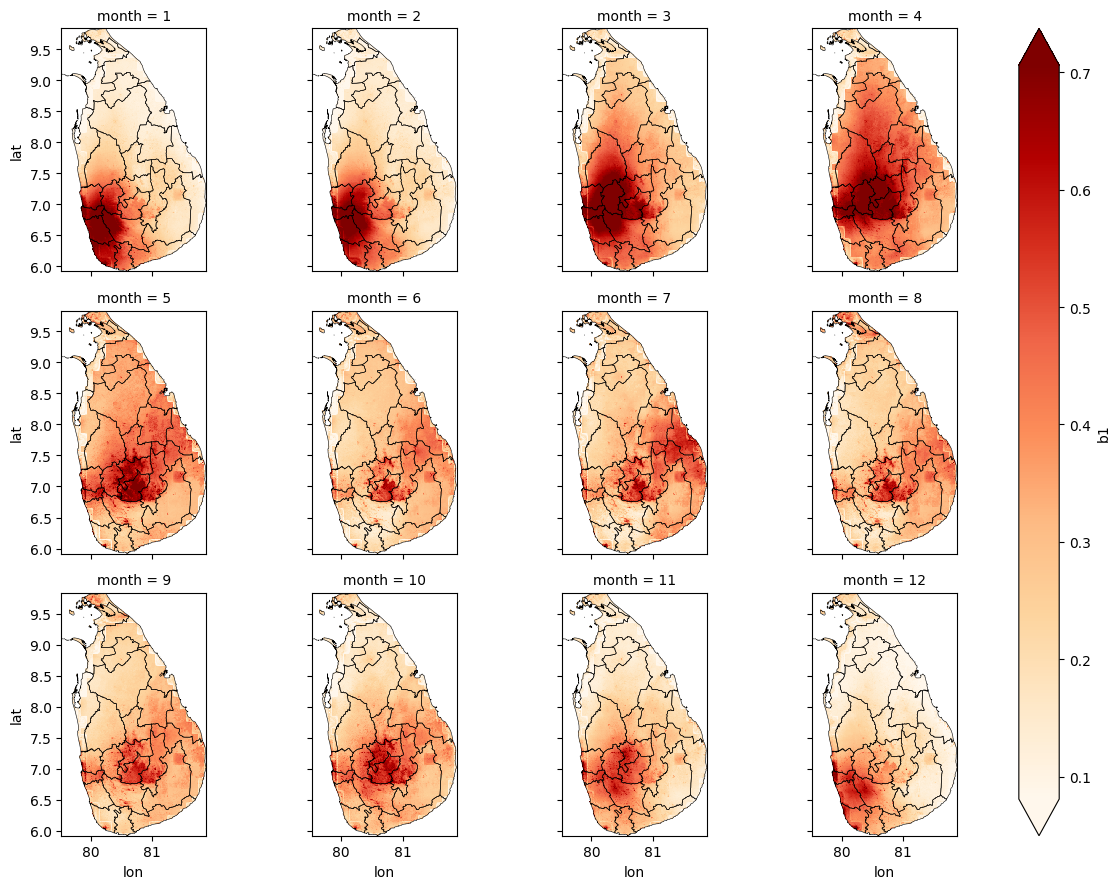

In [ ]:
# --- Your original plot ---
fig = monthly_mean_scaled.b1.plot(
    x="lon",
    y="lat",
    col="month",
    robust=True,
    cmap="OrRd",
    col_wrap=4
)

# --- Overlay district boundaries (thin lines, not too dark) ---
for ax in fig.axes.flat:
    districts.boundary.plot(ax=ax, color="black", linewidth=0.4)

# --- Save final map ---
plt.savefig("Monthly_PM25_with_districts.png", dpi=360, bbox_inches="tight")
plt.show()

/tmp/ipython-input-513390610.py:17: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fig.axes.flat:


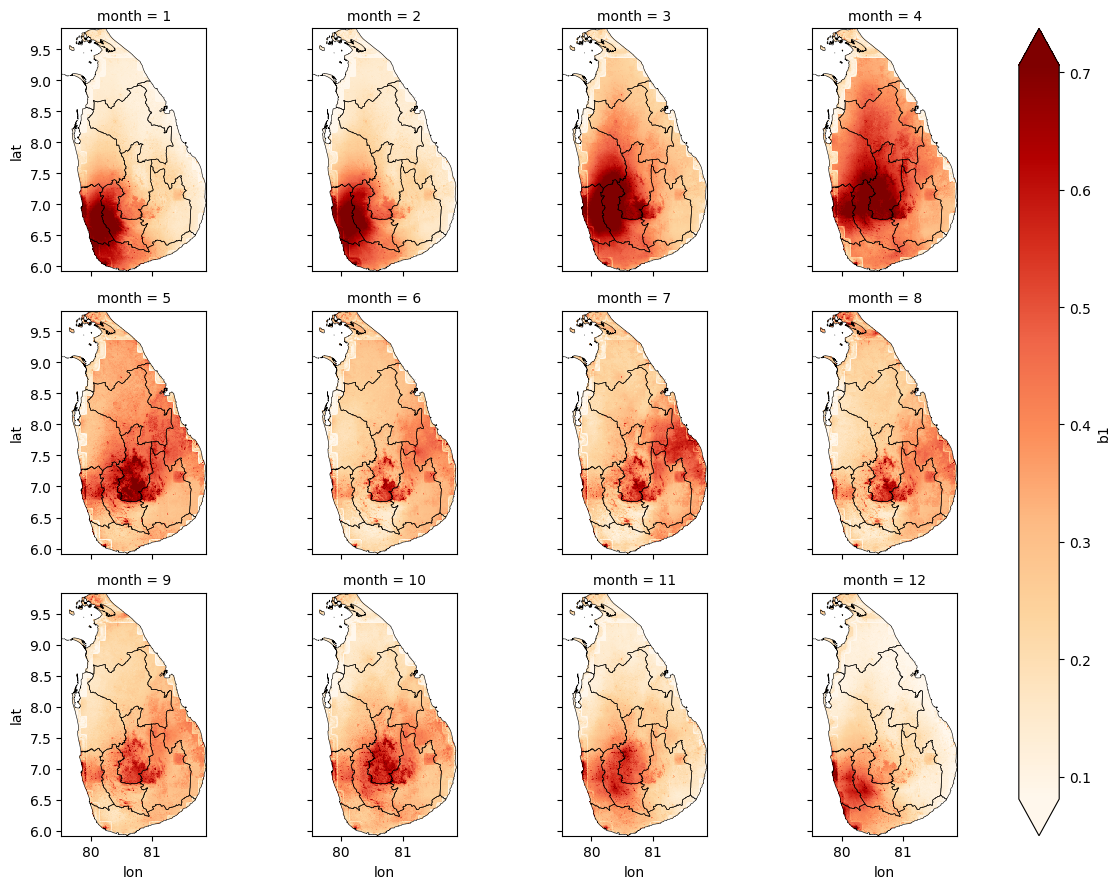

In [ ]:
# --- Load province boundaries (Level 1 for Sri Lanka) ---
gaul_provinces = (ee.FeatureCollection("FAO/GAUL/2015/level1")
                  .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))
provinces = geemap.ee_to_gdf(gaul_provinces).to_crs(epsg=4326)

# --- Your original plot (unchanged) ---
fig = monthly_mean_scaled.b1.plot(
    x="lon",
    y="lat",
    col="month",
    robust=True,
    cmap="OrRd",
    col_wrap=4
)

# --- Overlay province boundaries (instead of districts) ---
for ax in fig.axes.flat:
    provinces.boundary.plot(ax=ax, color="black", linewidth=0.4)

# --- Save final map ---
plt.savefig("Monthly_PM25_with_provinces.png", dpi=360, bbox_inches="tight")
plt.show()

In [ ]:
# --- Load GAUL district boundaries (Level 2 for Sri Lanka) ---
gaul = (ee.FeatureCollection("FAO/GAUL/2015/level2")
        .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))

# Convert GAUL districts to GeoDataFrame and reproject to WGS84
districts = geemap.ee_to_gdf(gaul).to_crs(epsg=4326)

In [ ]:
save_path = '/content/drive/MyDrive/Research/2017-2022/monthly_mean_scaled.nc'
monthly_mean_scaled.to_netcdf(save_path)
print(f"Dataset saved at: {save_path}")


Dataset saved at: /content/drive/MyDrive/Research/2017-2022/monthly_mean_scaled.nc


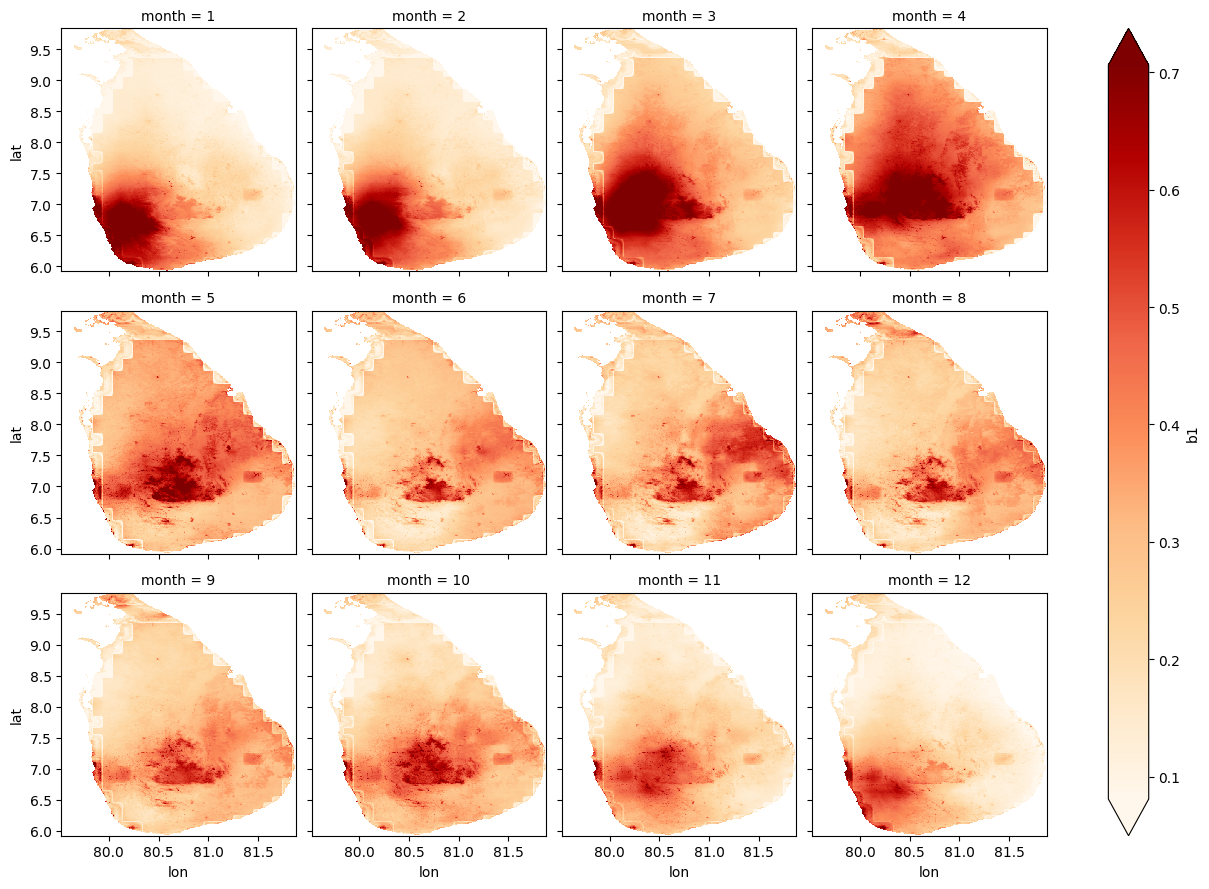

In [ ]:
monthly_mean_scaled.b1.plot(
    x="lon",
    y="lat",
    col="month",
    robust=True,
    cmap="OrRd",
    col_wrap=4
)

plt.savefig("Monthly_PM25.png", dpi=360, bbox_inches="tight")

Take a collection of images (daily, weekly, etc.) of any variable.

Filter the images for a specific month.

Compute the pixel-wise mean for that month.

Return a single image representing the monthly average.

The monthly function combined with time_list.map(...) works month by month for each year.

time_list contains every month individually, not just “January, February…” once.

So if your time range is 2016–2024, time_list will contain January 2016, February 2016, …, December 2023 (and so on).


def monthly(date, col):
  start_date = ee.Date(date)
  end_date = start_date.advance(1, 'month')
  img = col.filterDate(start_date, end_date).mean()
  return img.set('system:time_start', start_date.millis())

smap_monthly = ee.ImageCollection(time_list.map(lambda x: monthly(x, smap)))



def min_max_scale_monthly(month_data, month_min, month_max):
    return (month_data - month_min) / (month_max - month_min)

# Apply min-max scaling for each month
scaled_monthly = xr.concat([
    min_max_scale_monthly(monthly_grouped.sel(month=m), monthly_min.sel(month=m), monthly_max.sel(month=m))
    for m in range(1,13)
], dim='month')